# Workgroup 5

- Janice Mamani

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from sklearn.linear_model import LassoCV
import sys
sys.path.insert(0, r'C:\Users\USUARIO\Documents\GitHub\hdmpy')
import hdmpy
import multiprocess as mp
import statsmodels.api as sm
import seaborn as sns
from scipy.stats import norm, ttest_ind, f_oneway
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from econml.grf import RegressionForest, CausalForest
from econml.dml import CausalForestDML
from econml.inference import BootstrapInference
from econml.sklearn_extensions.linear_model import WeightedLassoCV

# Descriptives

In [13]:
## loading the data
df = pd.read_csv('processed_esti.csv')
df

,y,w,gender_female,gender_male,gender_transgender,ethnicgrp_asian,ethnicgrp_black,ethnicgrp_mixed_multiple,ethnicgrp_other,ethnicgrp_white,partners1,postlaunch,msm,age,imd_decile
0,1,1,0,1,0,0,0,1,0,0,0,1,0,27,5
1,0,0,0,1,0,0,0,0,0,1,0,0,0,19,6
2,0,1,0,1,0,0,1,0,0,0,0,1,0,26,4
3,0,0,1,0,0,0,0,0,0,1,1,0,0,20,2
4,1,1,1,0,0,1,0,0,0,0,0,1,0,24,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1734,0,0,0,1,0,0,0,0,0,1,0,0,0,24,8
1735,1,1,1,0,0,0,1,0,0,0,1,1,0,29,1
1736,1,1,1,0,0,0,0,0,0,1,0,1,0,27,4
1737,0,1,1,0,0,0,0,0,0,1,1,1,0,25,4


In [14]:
variables = [
    'y', 'w', 'gender_female', 'gender_male', 'gender_transgender',
    'ethnicgrp_asian', 'ethnicgrp_black', 'ethnicgrp_mixed_multiple',
    'ethnicgrp_other', 'ethnicgrp_white', 'partners1', 'postlaunch',
    'age', 'imd_decile'
]

In [15]:
control_group = df[df['w'] == 0]
treatment_group = df[df['w'] == 1]

def calculate_stats(variable):
    control_mean = control_group[variable].mean()
    control_std = control_group[variable].std()
    treatment_mean = treatment_group[variable].mean()
    treatment_std = treatment_group[variable].std()
    diff = sm.OLS(df[variable], sm.add_constant(df['w'])).fit().params[1]
    return control_mean, control_std, treatment_mean, treatment_std, diff

# Create the balance table
balance_table = pd.DataFrame(columns=['Control mean', 'Control sd', 'Treatment mean', 'Treatment sd', 'Diff'])


In [16]:
for var in variables:
    control_mean, control_std, treatment_mean, treatment_std, diff = calculate_stats(var)
    balance_table.loc[var] = [control_mean, control_std, treatment_mean, treatment_std, diff]

# Display the balance table
balance_table

,Control mean,Control sd,Treatment mean,Treatment sd,Diff
y,0.211491,0.408616,0.476656,0.499726,0.265164
w,0.000000,0.000000,1.000000,0.000000,1.000000
gender_female,0.580685,0.493749,0.587405,0.492569,0.006720
gender_male,0.418093,0.493547,0.409338,0.491979,-0.008755
gender_transgender,0.001222,0.034964,0.003257,0.057011,0.002035
ethnicgrp_asian,0.055012,0.228144,0.071661,0.258066,0.016649
ethnicgrp_black,0.092910,0.290483,0.080347,0.271978,-0.012562
ethnicgrp_mixed_multiple,0.092910,0.290483,0.084691,0.278572,-0.008219
ethnicgrp_other,0.017115,0.129779,0.009772,0.098423,-0.007343
ethnicgrp_white,0.742054,0.437772,0.753529,0.431190,0.011475


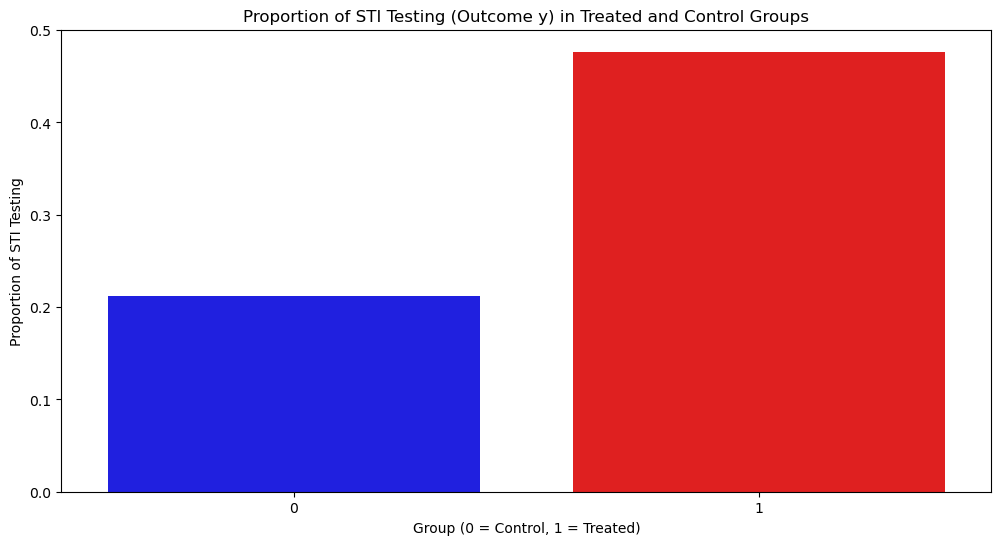

In [17]:
plt.figure(figsize=(12, 6))
sns.barplot(x='w', y='y', data=df, palette=['blue', 'red'], errorbar=None)
plt.title('Proportion of STI Testing (Outcome y) in Treated and Control Groups')
plt.xlabel('Group (0 = Control, 1 = Treated)')
plt.ylabel('Proportion of STI Testing')
plt.show()


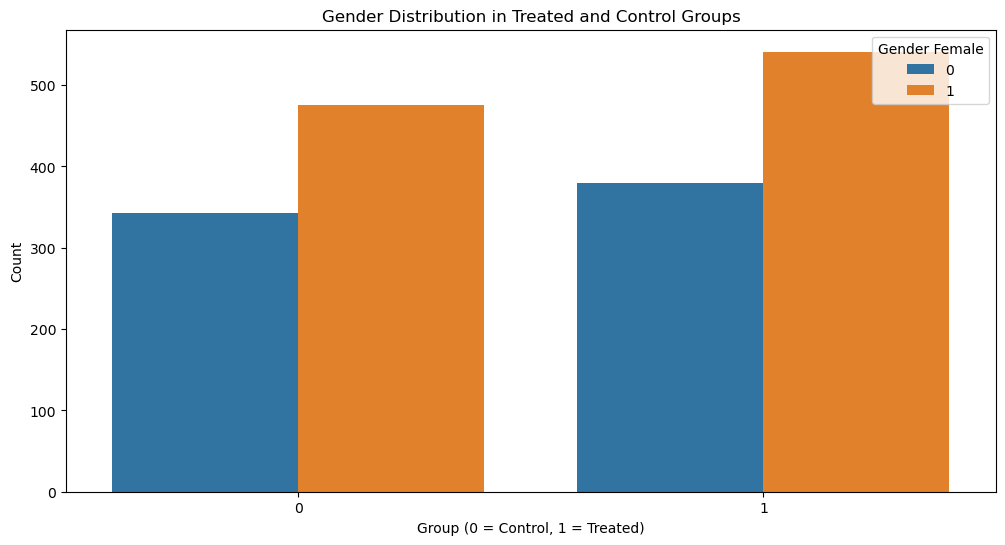

In [18]:
# Gender Distribution in Treated and Control Groups
plt.figure(figsize=(12, 6))
sns.countplot(x='w', hue='gender_female', data=df)
plt.title('Gender Distribution in Treated and Control Groups')
plt.xlabel('Group (0 = Control, 1 = Treated)')
plt.ylabel('Count')
plt.legend(title='Gender Female', loc='upper right')
plt.show()


In [19]:
sns.set(style="whitegrid")

# Define a function to plot density plots for each group separately
def plot_separate_density_plots(variable):
    plt.figure(figsize=(14, 6))

    # Plot for Treated group
    plt.subplot(1, 2, 1)
    sns.kdeplot(treatment_group[variable], color='blue', shade=True, alpha=0.6)
    plt.title(f'Treated Group - Density Plot of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Density')

    # Plot for Control group
    plt.subplot(1, 2, 2)
    sns.kdeplot(control_group[variable], color='red', shade=True, alpha=0.6)
    plt.title(f'Control Group - Density Plot of {variable}')
    plt.xlabel(variable)
    plt.ylabel('Density')

    plt.tight_layout()
    plt.show()



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



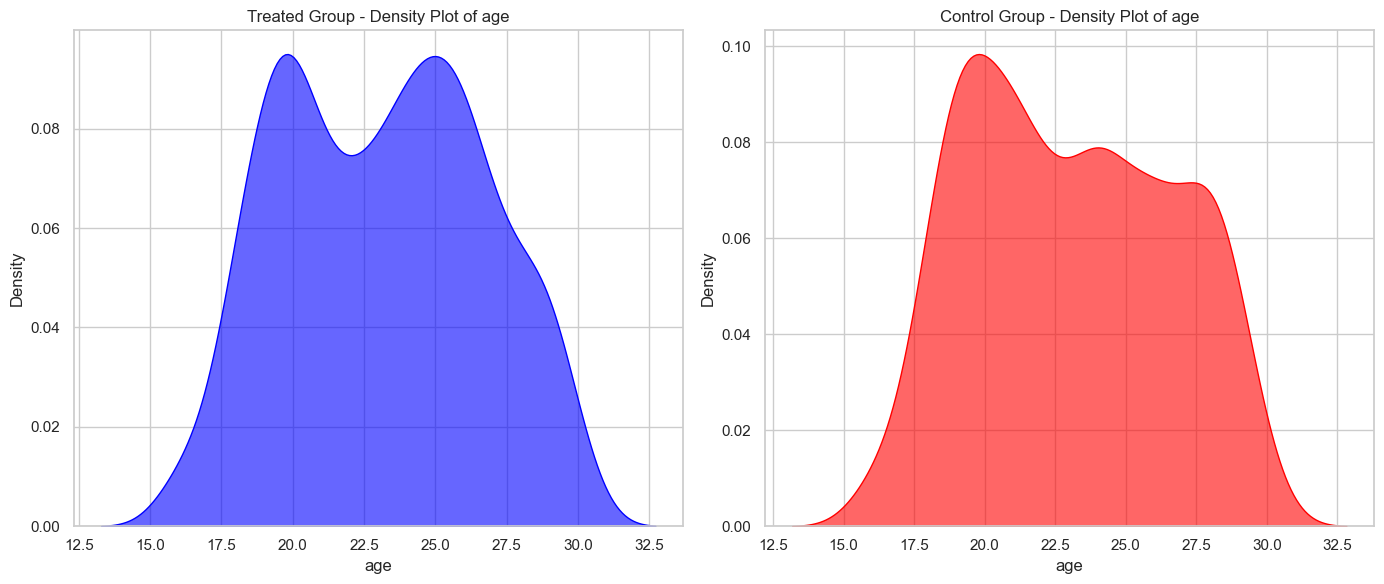



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



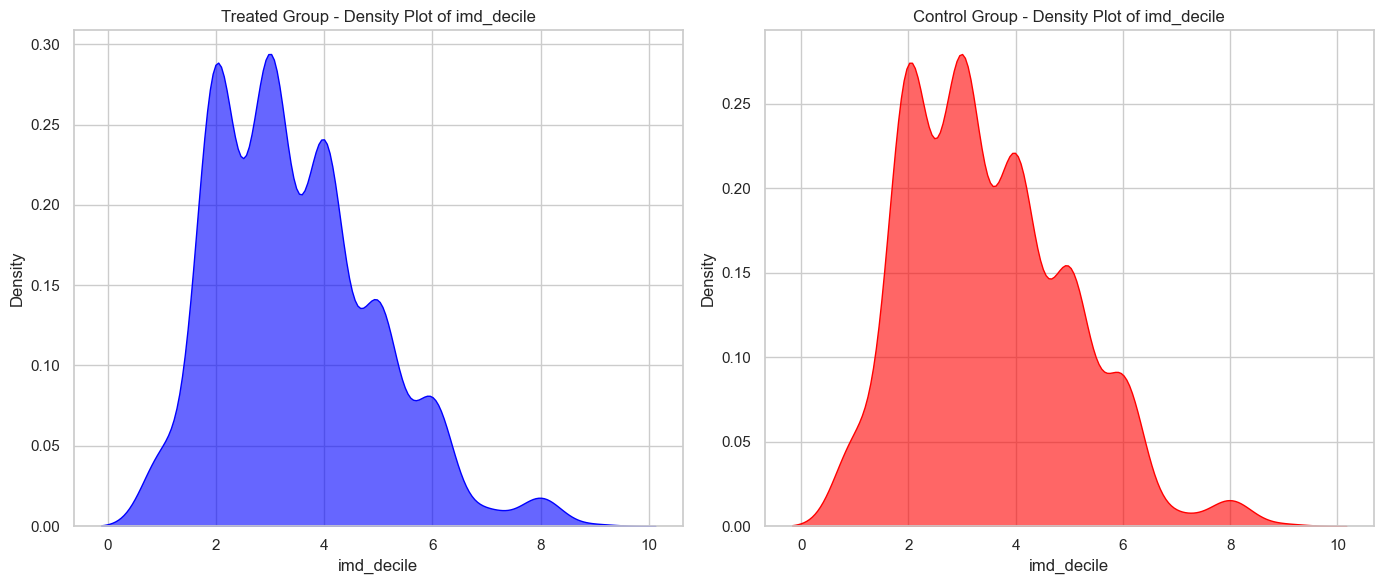

In [20]:
plot_separate_density_plots('age')
plot_separate_density_plots('imd_decile')

In [21]:
# Setting up the visualisation style
sns.set(style="whitegrid")

# Define a function to plot combined density plots for both groups
def plot_combined_density_plots(variable):
    plt.figure(figsize=(14, 6))

    # Plot for Treated and Control groups combined in one plot
    plt.subplot(1, 2, 1)
    sns.kdeplot(treatment_group[variable], color='blue', shade=True, alpha=0.6, label='Treated Group')
    sns.kdeplot(control_group[variable], color='red', shade=True, alpha=0.6, label='Control Group')
    plt.title(f'Density Plot of {variable} - Treated vs Control')
    plt.xlabel(variable)
    plt.ylabel('Density')
    plt.legend()

    plt.tight_layout()
    plt.show()



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



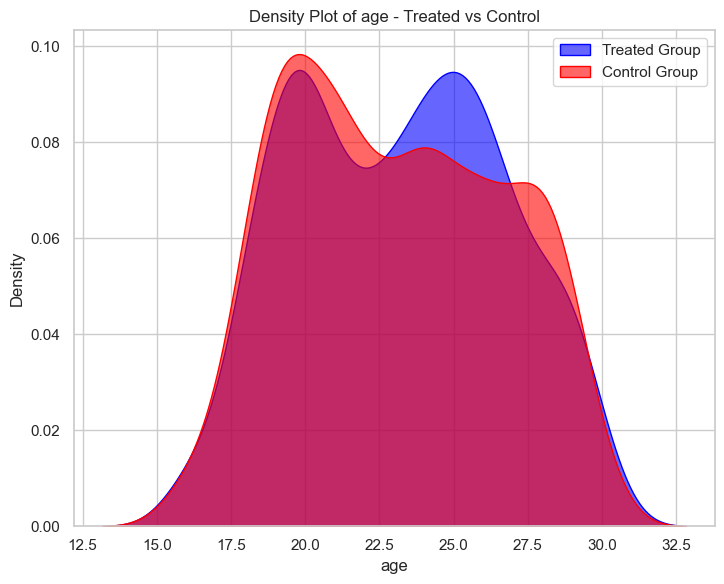



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.



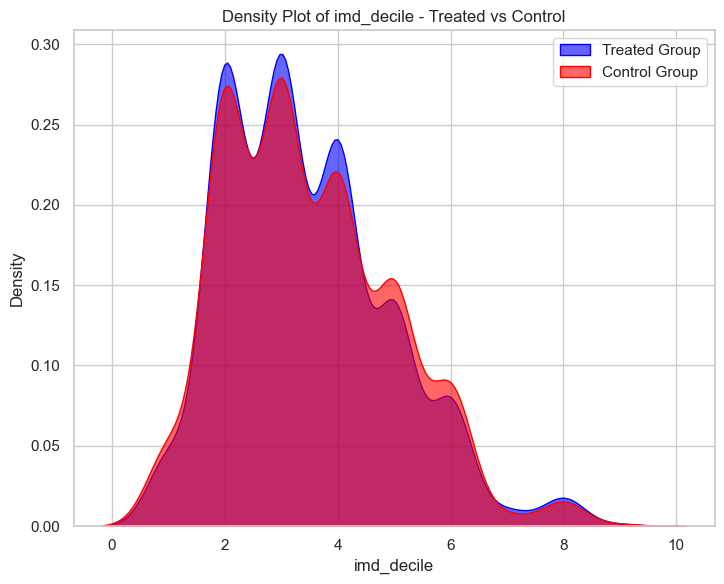

In [22]:
# Example usage:
plot_combined_density_plots('age')
plot_combined_density_plots('imd_decile')

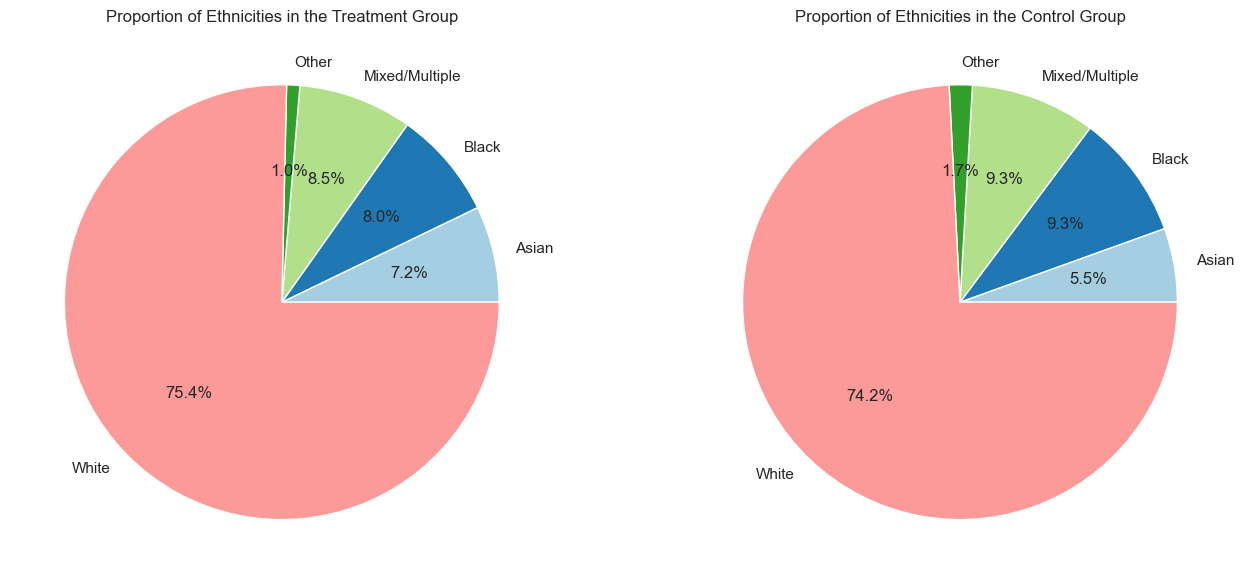

In [23]:
ethnicities = ['ethnicgrp_asian', 'ethnicgrp_black', 'ethnicgrp_mixed_multiple', 'ethnicgrp_other', 'ethnicgrp_white']

treatment_counts = treatment_group[ethnicities].sum()
treatment_proportions = treatment_counts / treatment_counts.sum()

control_counts = control_group[ethnicities].sum()
control_proportions = control_counts / control_counts.sum()

ethnicity_labels = {
    'ethnicgrp_asian': 'Asian',
    'ethnicgrp_black': 'Black',
    'ethnicgrp_mixed_multiple': 'Mixed/Multiple',
    'ethnicgrp_other': 'Other',
    'ethnicgrp_white': 'White'
}


treatment_proportions = treatment_proportions.rename(index=ethnicity_labels)
control_proportions = control_proportions.rename(index=ethnicity_labels)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
treatment_proportions.plot.pie(autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Proportion of Ethnicities in the Treatment Group')
plt.ylabel('')

plt.subplot(1, 2, 2)
control_proportions.plot.pie(autopct='%1.1f%%', colors=plt.cm.Paired.colors)
plt.title('Proportion of Ethnicities in the Control Group')
plt.ylabel('')

plt.tight_layout()
plt.show()


# Linear Regression Analysis

### Model 1: Y ~ T

In [24]:
Y = df['y']
T = df["w"]
T = sm.add_constant(T)
model1 = sm.OLS(Y,T).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.077
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     144.5
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           4.96e-32
Time:                        15:47:47   Log-Likelihood:                -1112.9
No. Observations:                1739   AIC:                             2230.
Df Residuals:                    1737   BIC:                             2241.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2115      0.016     13.174      0.0

In [25]:
est_ols= model1.summary2().tables[1]['Coef.']['w']
est_ols

0.2651643663605783

### Model 2: Y ~ T + X

In [26]:
X = df[['w','gender_female','gender_transgender','ethnicgrp_asian','ethnicgrp_black','ethnicgrp_mixed_multiple','ethnicgrp_white','partners1','postlaunch','msm',	'age','imd_decile']]
X = sm.add_constant(X)
model2 = sm.OLS(Y,X).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.115
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     18.64
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           1.76e-38
Time:                        15:47:51   Log-Likelihood:                -1076.4
No. Observations:                1739   AIC:                             2179.
Df Residuals:                    1726   BIC:                             2250.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [53]:
est_controls= model2.summary2().tables[1]['Coef.']['w']
est_controls

0.25622378848202354

## Double Lasso

In [27]:
# Prepare data for Lasso regression
features = df.drop(columns=['y'])
target = df['y']

# Perform LassoCV to select important features
lasso = LassoCV(cv=5, random_state=0).fit(features, target)


# Select features based on LassoCV
selected_features = features.columns[(lasso.coef_ != 0)]

# Ensure that the treatment variable 'w' is included in the selected features
if 'w' not in selected_features:
    selected_features = ['w'] + list(selected_features)

# Model 3: Y ~ T + selected features from Lasso
X3 = df[selected_features]
X3 = sm.add_constant(X3)
model3 = sm.OLS(Y, X3).fit()

# Print model 3 summary
print(model3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     31.49
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           2.60e-41
Time:                        15:47:54   Log-Likelihood:                -1078.1
No. Observations:                1739   AIC:                             2172.
Df Residuals:                    1731   BIC:                             2216.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1007      0.079     

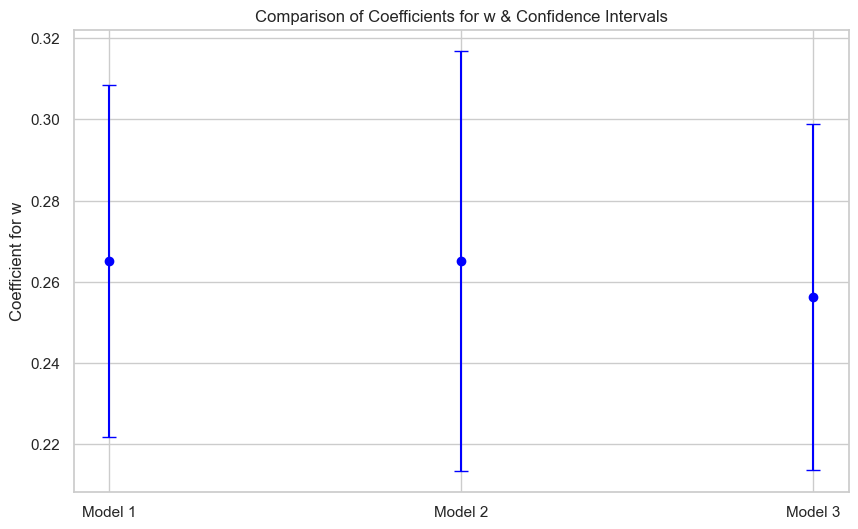

In [28]:
# Extract coefficients and confidence intervals for T from each model
coeffs = {
    'Model 1': model1.params['w'],
    'Model 2': model1.params['w'],
    'Model 3': model2.params['w']
}

conf_intervals = {
    'Model 1': model1.conf_int().loc['w'],
    'Model 2': model2.conf_int().loc['w'],
    'Model 3': model3.conf_int().loc['w']
}

# Plot the coefficients and confidence intervals
plt.figure(figsize=(10, 6))
models = list(coeffs.keys())
estimates = list(coeffs.values())
ci_lower = [conf_intervals[model][0] for model in models]
ci_upper = [conf_intervals[model][1] for model in models]

plt.errorbar(models, estimates, yerr=[estimates[i] - ci_lower[i] for i in range(len(models))], fmt='o', capsize=5, color='blue')
plt.title('Comparison of Coefficients for w & Confidence Intervals')
plt.xlabel('')
plt.ylabel('Coefficient for w')
plt.grid(True)
plt.show()


# Non-Linear Methods DML

In [47]:
# Define the outcome variable and the treatment variable
Y = df['y']
W = df['w']
X = df.drop(columns=['y', 'w'])

X_train, X_test, y_train, y_test, T_train, T_test = train_test_split(X, Y, W, test_size=0.2, random_state=1)

## Lasso using DML

In [75]:
lasso_y = LassoCV(cv=5).fit(X_train, y_train)
lasso_t = LassoCV(cv=5).fit(X_train, T_train)

y_train_hat = lasso_y.predict(X_train)
T_train_hat = lasso_t.predict(X_train)
y_resid = y_train - y_train_hat
T_resid = T_train - T_train_hat

resid_model = sm.OLS(y_resid, sm.add_constant(T_resid)).fit()
treatment_effect_estimate = resid_model.params[0]
treatment_effect_summary = resid_model.summary()
print(treatment_effect_estimate)
print(treatment_effect_summary)



-4.391018798566293e-17
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     119.7
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           8.87e-27
Time:                        16:21:25   Log-Likelihood:                -852.16
No. Observations:                1391   AIC:                             1708.
Df Residuals:                    1389   BIC:                             1719.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.391e-17      0.

## Regression Trees using DML

In [74]:
# Step 1: Learn Y and T using Decision Trees
tree_y = DecisionTreeRegressor().fit(X_train, y_train)
tree_t = DecisionTreeRegressor().fit(X_train, T_train)

# Step 2: Get residuals
Y_residuals = y_test - tree_y.predict(X_test)
T_residuals = T_test - tree_t.predict(X_test)

# Step 3: Run OLS on residuals
tree_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()

print(tree_model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     26.76
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           3.92e-07
Time:                        16:21:16   Log-Likelihood:                -295.98
No. Observations:                 348   AIC:                             596.0
Df Residuals:                     346   BIC:                             603.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.031      0.075      0.9

##  Boosting Trees using DML

In [77]:
# Step 1: Learn Y and T using Boosting Trees
boost_y = GradientBoostingRegressor().fit(X_train, y_train)
boost_t = GradientBoostingRegressor().fit(X_train, T_train)

# Step 2: Get residuals
Y_residuals = y_test - boost_y.predict(X_test)
T_residuals = T_test - boost_t.predict(X_test)

# Step 3: Run OLS on residuals
boosting_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()

print(boosting_model.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           6.12e-06
Time:                        16:21:56   Log-Likelihood:                -225.05
No. Observations:                 348   AIC:                             454.1
Df Residuals:                     346   BIC:                             461.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0206      0.025      0.826      0.4

## Regression Forest using DML

In [79]:
# Create and fit Regression Forest models
model_y = RandomForestRegressor()
model_t = RandomForestRegressor()


In [85]:
# Step 1: Learn Y and T using specified models
model_y.fit(X_train, y_train)
model_t.fit(X_train, T_train)

# Step 2: Get residuals
Y_residuals = y_test - model_y.predict(X_test)
T_residuals = T_test - model_t.predict(X_test)

# Step 3: Run OLS on residuals
forest_model = sm.OLS(Y_residuals, sm.add_constant(T_residuals)).fit()
print(forest_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     25.83
Date:                Sun, 16 Jun 2024   Prob (F-statistic):           6.11e-07
Time:                        16:30:41   Log-Likelihood:                -250.33
No. Observations:                 348   AIC:                             504.7
Df Residuals:                     346   BIC:                             512.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.027     -0.046      0.9

## RESULTS

In [106]:
def get_model_results(model, coef_name='w'):
    coef = model.params[coef_name]
    std_err = model.bse[coef_name]
    p_value = model.pvalues[coef_name]
    conf_int = model.conf_int().loc[coef_name]
    
    return {
        'Coef': coef,
        'SD': std_err,
        'P-Value': p_value,
        'Lower bound': conf_int[0],
        'Upper bound': conf_int[1]
    }

model_results = {
    'Lasso Regression': get_model_results(resid_model),
    'Tree Regression': get_model_results(tree_model),
    'Boosting Regression': get_model_results(boosting_model),
    'Forest Regression': get_model_results(forest_model)
}

results_df = pd.DataFrame(model_results).T
results_df


,Coef,SD,P-Value,Lower bound,Upper bound
Lasso Regression,0.262334,0.023980,8.871423e-27,0.215294,0.309374
Tree Regression,0.240318,0.046460,3.917285e-07,0.148939,0.331697
Boosting Regression,0.228489,0.049743,6.115373e-06,0.130653,0.326326
Forest Regression,0.242002,0.047614,6.106354e-07,0.148353,0.335650


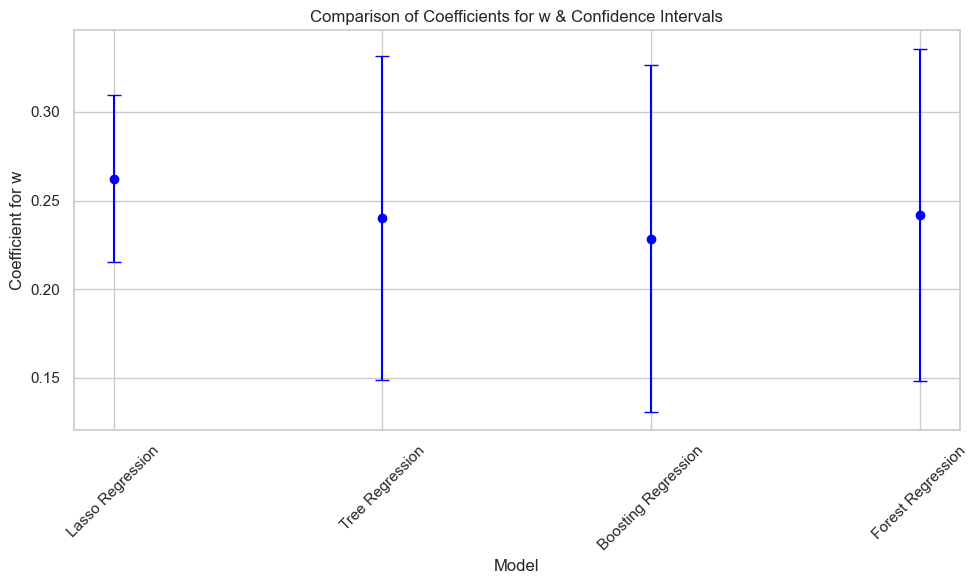

In [116]:
# Extract the data for the plot
coefficients = results_df['Coef']
standard_errors = results_df['SD']
lower_limits = results_df['Lower bound']
upper_limits = results_df['Upper bound']
models = results_df.index

# Calculate the error bars
ci_lower = coefficients - lower_limits
ci_upper = upper_limits - coefficients

# Plot the coefficients and confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(models, coefficients, yerr=[ci_lower, ci_upper], fmt='o', capsize=5, color='blue')
plt.title('Comparison of Coefficients for w & Confidence Intervals')
plt.xlabel('Model')
plt.ylabel('Coefficient for w')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# Recommendation: Utilizing Lasso for DML

* Model Interpretability: By setting some coefficients to zero, Lasso creates sparse models, which enhances the clarity and interpretability of the model.

* Effective Variable Selection: Lasso's capability to shrink some coefficients to zero helps in selecting relevant variables, thus improving model generalization and mitigating overfitting.

* Regularization Benefits: The regularization component of Lasso penalizes large coefficients, which helps to prevent overfitting and yields a more robust model, especially in the presence of correlated variables.

* Overall Performance: Although methods like decision trees, boosting trees, and random forests are powerful, they might introduce complexity and overfitting issues when applied to DML. Lasso, being simpler and more interpretable, presents a clear advantage for DML applications.

In summary, the Lasso method strikes a balance between simplicity, interpretability, and performance, making it a suitable choice for your Double Machine Learning tasks.